In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.relativedelta import relativedelta

from scipy.stats import boxcox
from scipy import stats

import datetime
import warnings
from itertools import product

%matplotlib inline

# Продажи автомобилей в Квебеке 1960-1968

Известны ежемесячные продажи автомобилей Квебеке в период с 1960 по 1968 гг. Необходимо построить прогноз на следующие 3 года.

In [32]:
df = pd.read_csv('data/monthly-car-sales-in-quebec-1960.csv', header=None,
                 names=['Month', 'Sales'], parse_dates=['Month'], index_col=['Month'])

In [33]:
df.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 1960-01-01 to 1968-12-01
Data columns (total 1 columns):
Sales    108 non-null int64
dtypes: int64(1)
memory usage: 1.7 KB


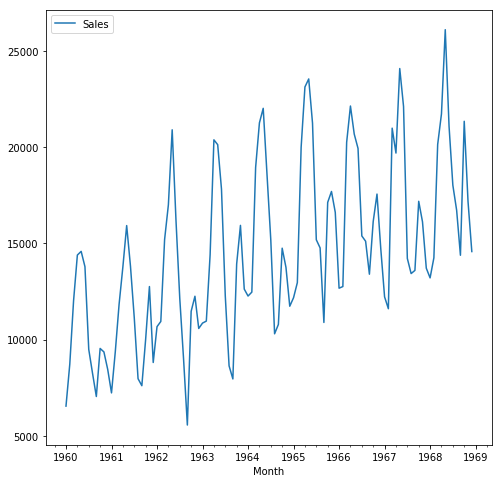

In [35]:
df.plot(figsize=(8,8))

Проверка стационарности и STL-декомпозиция ряда:

In [36]:
fulered = adfuller(df['Sales'])
print("P-value of dikki-fuller is {0}".format(fulered[1]))

P-value of dikki-fuller is 0.6632691049832871


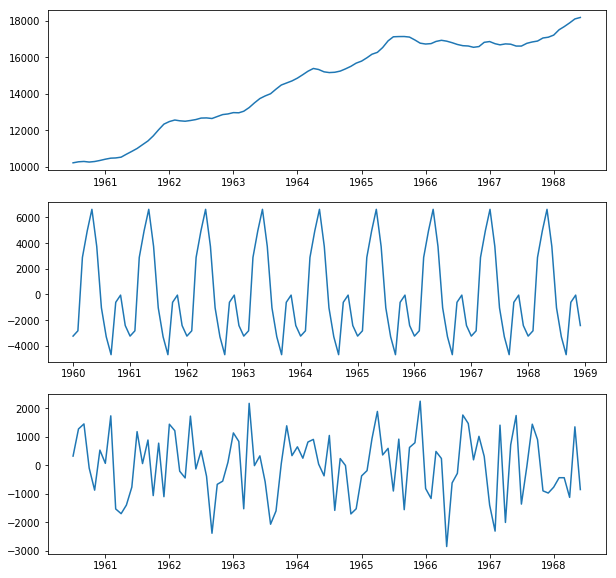

In [37]:
fig = plt.figure(figsize=(10,10))
seasoned = seasonal_decompose(df['Sales'])
plt.subplot(3,1,1)
plt.plot(seasoned.trend)
plt.subplot(3,1,2)
plt.plot(seasoned.seasonal)
plt.subplot(3,1,3)
plt.plot(seasoned.resid)

# Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [38]:
bc = boxcox(df['Sales'])
df['BoxCox'] = bc[0]
bc_fulered = adfuller(bc[0])
print("P-value of boxed-coxed data: {0}".format(bc_fulered[1]))
lmbd = bc[1]

P-value of boxed-coxed data: 0.6204806968215039


# Стационарность

Что с гипотезей нестационарности и трендом? Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

P-value of dikki-fuller is 0.008886757099226796


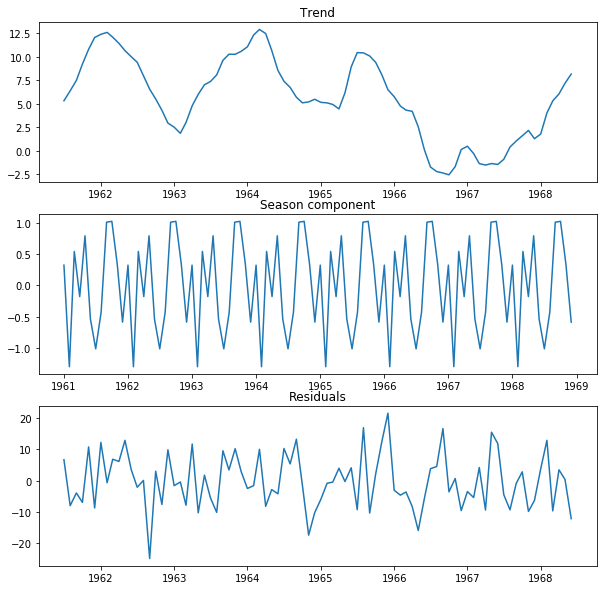

In [39]:
df['sales_box_diff'] = df['BoxCox'] - df['BoxCox'].shift(12)
df.dropna(inplace=True)
# seasonal_decompose и adfuller
fulered = adfuller(df['sales_box_diff'])
print("P-value of dikki-fuller is {0}".format(fulered[1]))
fig = plt.figure(figsize=(10,10))
seasoned = seasonal_decompose(df["sales_box_diff"])
plt.subplot(3,1,1)
plt.title("Trend")
plt.plot(seasoned.trend)
plt.subplot(3,1,2)
plt.title("Season component")
plt.plot(seasoned.seasonal)
plt.subplot(3,1,3)
plt.title("Residuals")
plt.plot(seasoned.resid)

P-value of dikki-fuller is 0.010424130539525968


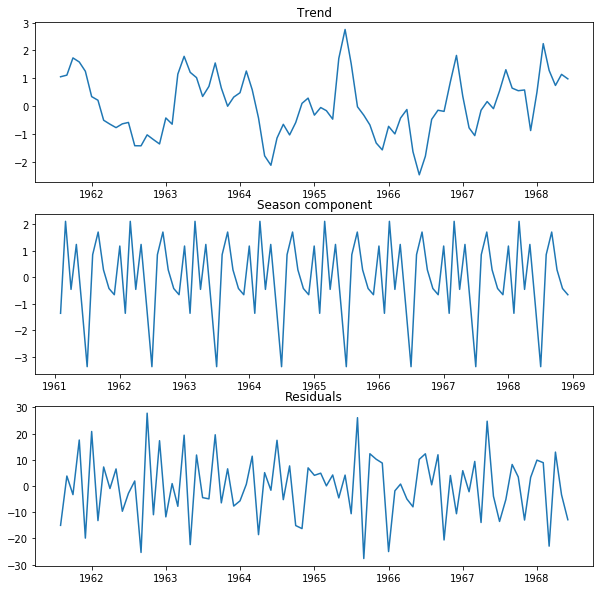

In [40]:
df['sales_box_diff2'] = df['sales_box_diff'] - df['sales_box_diff'].shift(1)
df.dropna(inplace=True)
# seasonal_decompose и adfuller
fulered = adfuller(df['sales_box_diff2'])
print("P-value of dikki-fuller is {0}".format(fulered[1]))
fig = plt.figure(figsize=(10,10))
seasoned = seasonal_decompose(df["sales_box_diff2"])
plt.subplot(3,1,1)
plt.title("Trend")
plt.plot(seasoned.trend)
plt.subplot(3,1,2)
plt.title("Season component")
plt.plot(seasoned.seasonal)
plt.subplot(3,1,3)
plt.title("Residuals")
plt.plot(seasoned.resid)

Принимаем ли гипотезу нестационарности? <br>
Да, т.к. заметна сезонность ряда

# Подбор модели

Посмотрим на ACF и PACF полученного ряда:

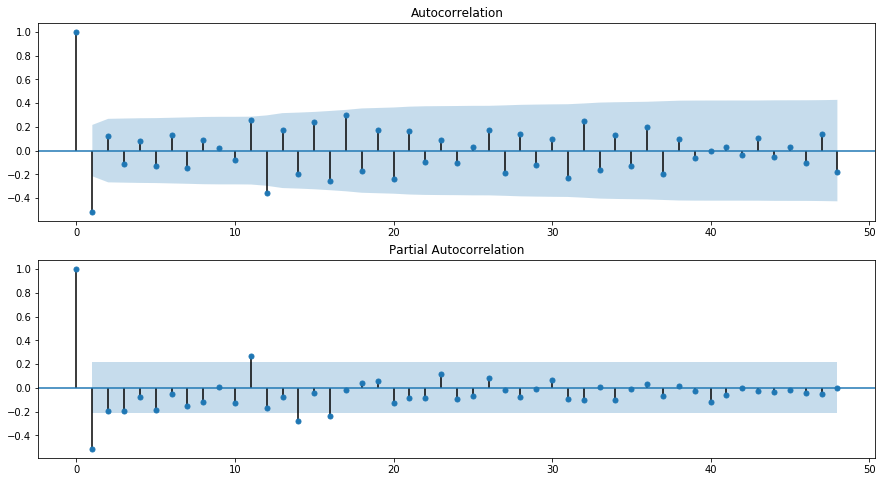

In [41]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['sales_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['sales_box_diff2'][13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: Q=1, q=3, P=1, p=3

In [42]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [43]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [44]:
df.head()

,Sales,BoxCox,sales_box_diff,sales_box_diff2
Month,,,,
1961-02-01,9374,141.932764,4.638190,-1.079547
1961-03-01,11837,158.189171,-1.168107,-5.806298
1961-04-01,13784,169.777088,-3.451155,-2.283047
1961-05-01,15926,181.541735,7.245455,10.696610
1961-06-01,13821,169.988407,0.171317,-7.074139


In [51]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(df['BoxCox'], order=(param[0], 1, param[1]) , seasonal_order=(param[2], 1, param[3], 12))
        model = model.fit()
        # обучаем модель tsa.statespace.SARIMAX
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
CPU times: user 5.02 s, sys: 10.2 s, total: 15.2 s
Wall time: 4.06 s


In [52]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
4   (0, 1, 0, 1)  600.731425
12  (1, 1, 0, 1)  601.173334
6   (0, 1, 1, 1)  602.678155
14  (1, 1, 1, 1)  603.133227
5   (0, 1, 1, 0)  603.758199


In [53]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             BoxCox   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -297.366
Date:                            Thu, 14 Dec 2017   AIC                            600.731
Time:                                    16:19:24   BIC                            608.393
Sample:                                02-01-1961   HQIC                           603.827
                                     - 12-01-1968                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7812      0.079     -9.877      0.000      -0.936      -0.626
ma.S.L12      -0.5130      0.123   

Критерий Стьюдента: p=0.426880
Критерий Дики-Фуллера: p=0.000000


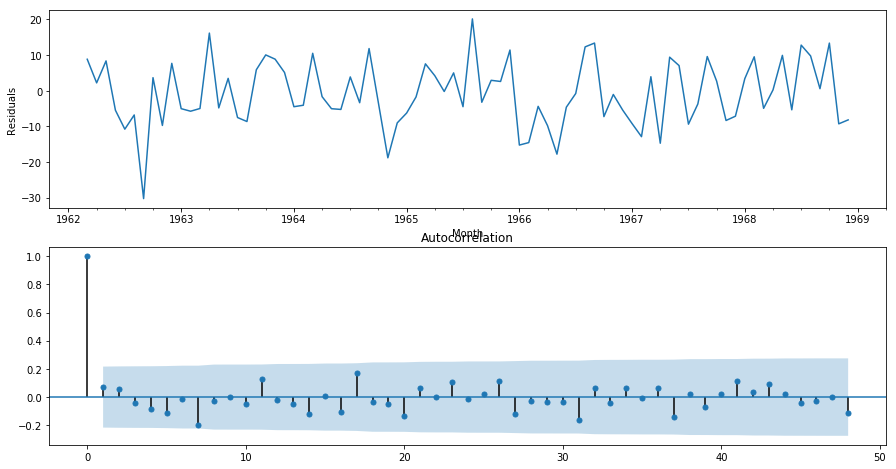

In [54]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

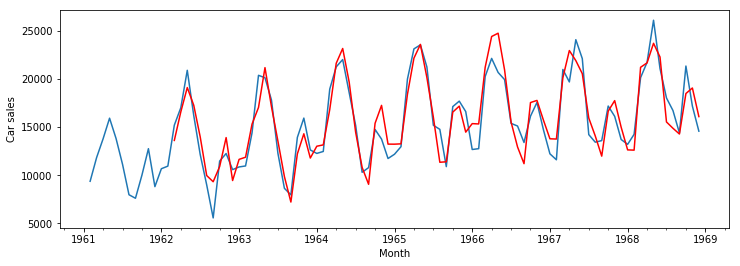

In [55]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
df['model'] = invboxcox(best_model.fittedvalues, lmbd)
plt.figure(figsize=(12,4))
df['Sales'].plot()
df['model'][13:].plot(color='r')
plt.ylabel('Car sales')
plt.show()

# Прогноз

In [73]:
df2 = df[['Sales']]
future = pd.DataFrame(index=date_list, columns=df2.columns)

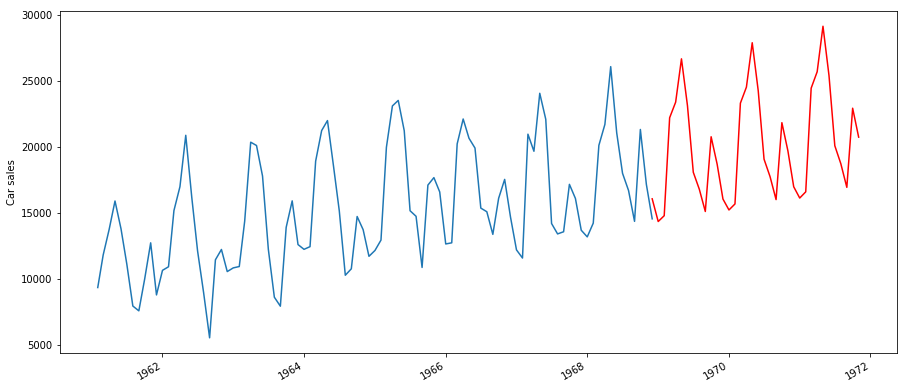

In [82]:
df2 = df[['Sales']]
date_list = [datetime.datetime.strptime("1968-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=94, end=130), lmbd)

plt.figure(figsize=(15,7))
df2['Sales'].plot()
df2['forecast'].plot(color='r')
plt.ylabel('Car sales')
plt.show()